In [1]:
import pandas as pd
import os
import sklearn.model_selection as sk_model_selection
import sklearn.preprocessing as sk_preprocessing
import sklearn.metrics as sk_metrics
import sklearn.neural_network as sk_nn
import matplotlib.pyplot as plt
import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

Ανάγνωση δεδομένων από τα αρχεία harth και ένωση δεδομένων στο dataframe concat.

In [3]:
data_dir = './harth'

files = os.listdir(data_dir)

concat = pd.DataFrame()

for root, _, files in os.walk(data_dir):
    for file in files:
        new = pd.read_csv(os.path.join(root, file), index_col = 'timestamp')
        file_name = os.path.splitext(file)[0]
        new['file_name'] = file_name
        concat = pd.concat([concat, new])
label = concat['label']
#concat.drop(labels = ['index', 'Unnamed: 0'], axis = 'columns', inplace = True)
concat.drop(labels = ['index'], axis = 'columns', inplace = True)
concat.reset_index(inplace = True)
concat['timestamp'] = pd.to_datetime(concat['timestamp']).apply(lambda x: x.timestamp())
time = concat['timestamp']

Ορισμός διανύσματος εισόδου και μεταβλητής εξόδου. Ως είσοδο παίνρουμε τις τιμές των επιταχυνσιόμετρων και ως έξοδο την τιμή του label, που καθορίζει τον τύπο της άσκησης.

In [5]:
X = concat.drop(columns = ['timestamp', 'label', 'file_name']).dropna()
y = concat.loc[X.index, 'label']

scaler = sk_preprocessing.MinMaxScaler(feature_range = (-1,1))
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = sk_model_selection.train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Αρχικοποίηση του ταξινομητή βασισμένου σε νευρωνικό δίκτυο.

In [6]:
nn_classifier = sk_nn.MLPClassifier(hidden_layer_sizes=(64, 64), activation='relu', max_iter=1000)
nn_classifier.fit(X_train, y_train)

nn_ypred = nn_classifier.predict(X_test)

accuracy = sk_metrics.accuracy_score(y_test, nn_ypred)

print('Test accuracy: {:0.2f}'.format(accuracy))

Test accuracy: 0.96


Δημιουργία του confusion matrix για τον ταξινομητή βασισμένο στα νευρωνικά δίκτυα.

In [8]:
nn_cm = sk_metrics.confusion_matrix(y_test, nn_ypred)
nn_results_df = pd.DataFrame({'y_test': y_test, 'nn_ypred': nn_ypred})

def categorize_prediction(row):
    if row['y_test'] == cls and row['nn_ypred'] == cls:
        return 'TP'
    elif row['y_test'] != cls and row['nn_ypred'] == cls:
        return 'FP'
    elif row['y_test'] == cls and row['nn_ypred'] != cls:
        return 'FN'
    else:
        return 'TN'
#results_df['category'] = results_df.apply(categorize_prediction, axis=1, args = (cls,))

nn_summary = []
classes = sorted(set(y))

for cls in classes:
    nn_results_df['category'] = nn_results_df.apply(categorize_prediction, axis=1)
    tp = ((nn_results_df['y_test'] == cls) & (nn_results_df['nn_ypred'] == cls)).sum()
    fp = ((nn_results_df['y_test'] != cls) & (nn_results_df['nn_ypred'] == cls)).sum()
    fn = ((nn_results_df['y_test'] == cls) & (nn_results_df['nn_ypred'] != cls)).sum()
    tn = ((nn_results_df['y_test'] != cls) & (nn_results_df['nn_ypred'] != cls)).sum()
    nn_summary.append({'Label': cls, 'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn})

nn_summary_df = pd.DataFrame(nn_summary)

print(nn_summary_df)

   Label     TP   FP   FN     TN
0      1  13778  608  382  12762
1      2   4360   35   71  23064
2      3     99  106  302  27023
3      4    556   90   92  26792
4      5    409  145   85  26891
5      6   1249  160  205  25916
6      7   2582   11   24  24913
7      8   3327   15    9  24179


Αρχικοποίηση του ταξινομητή βασισμένου σε random forests.

In [9]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

rf_ypred = rf_classifier.predict(X_test)
accuracy = sk_metrics.accuracy_score(y_test, rf_ypred)
print('Test accuracy: {:0.2f}'.format(accuracy))
print(max(y))

Test accuracy: 0.98
8


Δημιουργία του confusion matrix για τον ταξινομητή βασισμένο σε random forests.

In [11]:
rf_cm = sk_metrics.confusion_matrix(y_test, rf_ypred)
rf_results_df = pd.DataFrame({'y_test': y_test, 'rf_ypred': rf_ypred})

def categorize_prediction(row):
    if row['y_test'] == cls and row['rf_ypred'] == cls:
        return 'TP'
    elif row['y_test'] != cls and row['rf_ypred'] == cls:
        return 'FP'
    elif row['y_test'] == cls and row['rf_ypred'] != cls:
        return 'FN'
    else:
        return 'TN'

rf_summary = []
classes = sorted(set(y))

for cls in classes:
    rf_results_df['category'] = rf_results_df.apply(categorize_prediction, axis=1)
    tp = ((rf_results_df['y_test'] == cls) & (rf_results_df['rf_ypred'] == cls)).sum()
    fp = ((rf_results_df['y_test'] != cls) & (rf_results_df['rf_ypred'] == cls)).sum()
    fn = ((rf_results_df['y_test'] == cls) & (rf_results_df['rf_ypred'] != cls)).sum()
    tn = ((rf_results_df['y_test'] != cls) & (rf_results_df['rf_ypred'] != cls)).sum()
    rf_summary.append({'Label': cls, 'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn})

rf_summary_df = pd.DataFrame(rf_summary)

print(rf_summary_df)

   Label     TP   FP   FN     TN
0      1  14032  294  128  13076
1      2   4414   17   17  23082
2      3    259   16  142  27113
3      4    624   43   24  26839
4      5    437   96   57  26940
5      6   1352   15  102  26061
6      7   2603    1    3  24923
7      8   3327    0    9  24194


Αρχικοποίηση του classifier βασισμένου στα bayesian networks.

In [12]:
bn_classifier = GaussianNB()
bn_classifier.fit(X_train, y_train)

# Προβλέψτε τις ετικέτες για το σύνολο δοκιμής
bn_ypred = bn_classifier.predict(X_test)
accuracy = sk_metrics.accuracy_score(y_test, bn_ypred)
print('Test accuracy: {:0.2f}'.format(accuracy))

Test accuracy: 0.79


Δημιουργία του confusion matrix για τον ταξινομητή βασισμένο σε bayesian networks. 

In [13]:
bn_cm = sk_metrics.confusion_matrix(y_test, bn_ypred)
bn_results_df = pd.DataFrame({'y_test': y_test, 'bn_ypred': bn_ypred})

def categorize_prediction(row):
    if row['y_test'] == cls and row['bn_ypred'] == cls:
        return 'TP'
    elif row['y_test'] != cls and row['bn_ypred'] == cls:
        return 'FP'
    elif row['y_test'] == cls and row['bn_ypred'] != cls:
        return 'FN'
    else:
        return 'TN'

bn_summary = []
classes = sorted(set(y))

for cls in classes:
    bn_results_df['category'] = bn_results_df.apply(categorize_prediction, axis=1)
    tp = ((bn_results_df['y_test'] == cls) & (bn_results_df['bn_ypred'] == cls)).sum()
    fp = ((bn_results_df['y_test'] != cls) & (bn_results_df['bn_ypred'] == cls)).sum()
    fn = ((bn_results_df['y_test'] == cls) & (bn_results_df['bn_ypred'] != cls)).sum()
    tn = ((bn_results_df['y_test'] != cls) & (bn_results_df['bn_ypred'] != cls)).sum()
    bn_summary.append({'Label': cls, 'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn})

bn_summary_df = pd.DataFrame(bn_summary)

print(bn_summary_df)

[1, 2, 3, 4, 5, 6, 7, 8]
   Label     TP    FP    FN     TN
0      1  11200  2352  2960  11018
1      2   2641  1526  1790  21573
2      3     19   299   382  26830
3      4    305   139   343  26743
4      5    403   195    91  26841
5      6   1362  1228    92  24848
6      7   2514    25    92  24899
7      8   3304    18    32  24176


Σχεδιασμός γραφικής παράστασης για τον ταξινομητή βασισμένο σε νευρωνικά δίκτυα.

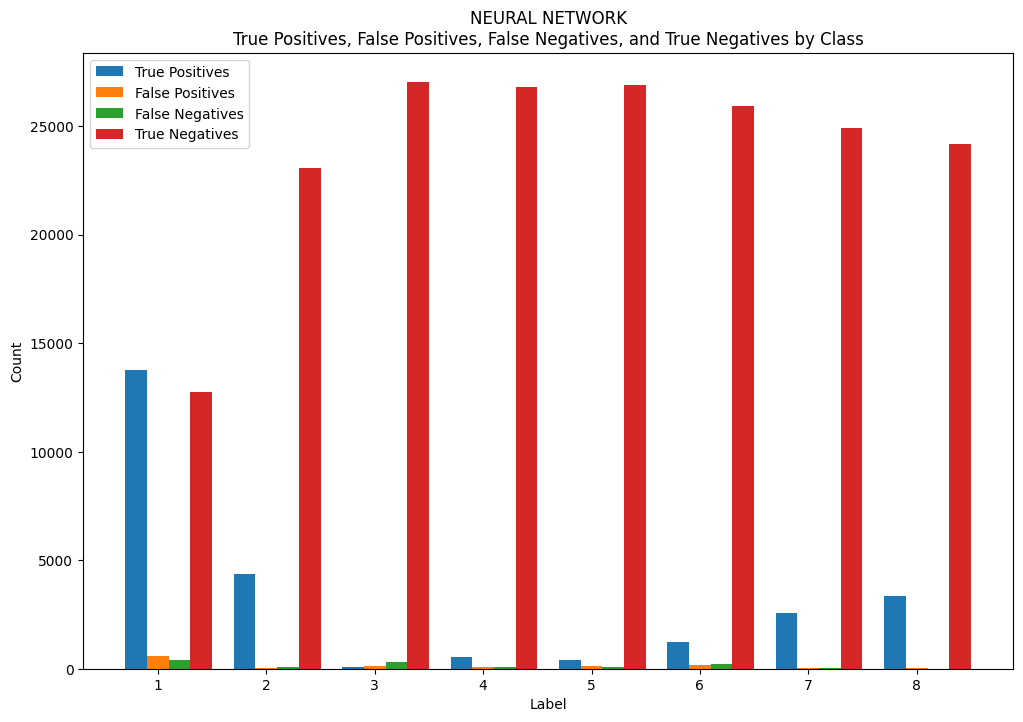

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.2
index = nn_summary_df['Label']

bar1 = plt.bar(index, nn_summary_df['TP'], bar_width, label='True Positives')
bar2 = plt.bar(index + bar_width, nn_summary_df['FP'], bar_width, label='False Positives')
bar3 = plt.bar(index + 2 * bar_width, nn_summary_df['FN'], bar_width, label='False Negatives')
bar4 = plt.bar(index + 3 * bar_width, nn_summary_df['TN'], bar_width, label='True Negatives')

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('NEURAL NETWORK\nTrue Positives, False Positives, False Negatives, and True Negatives by Class')
plt.xticks(index + bar_width, nn_summary_df['Label'])
plt.legend()
plt.show()

Σχεδιασμός γραφικής παράστασης για τον ταξινομητή βασισμένο σε random forests.

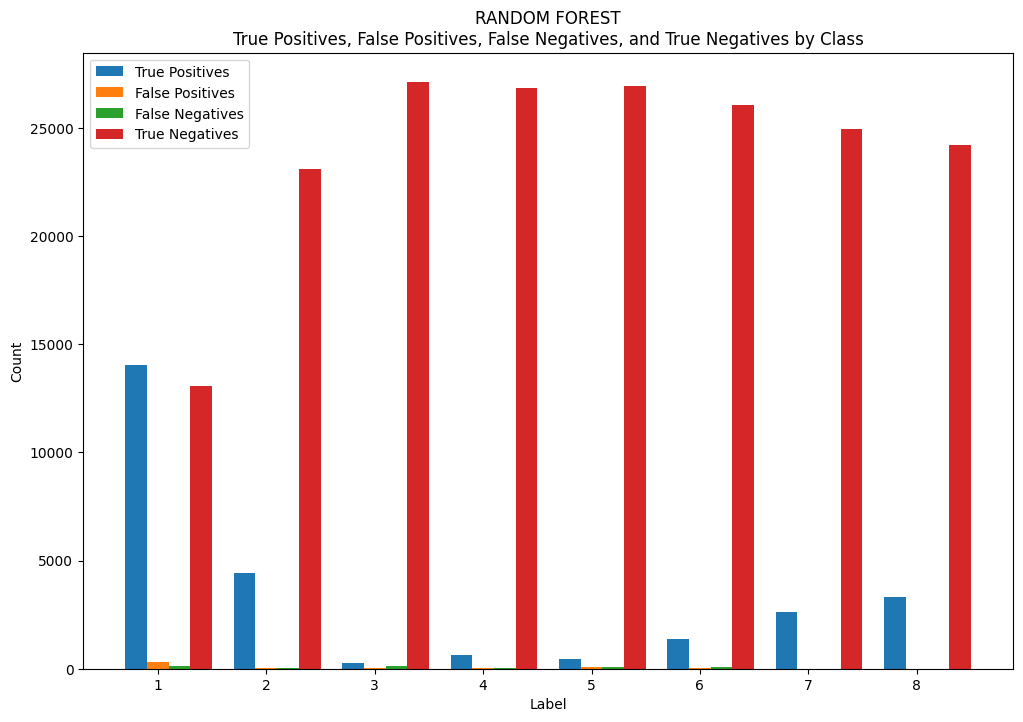

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.2

index = rf_summary_df['Label']

bar1 = plt.bar(index, rf_summary_df['TP'], bar_width, label='True Positives')
bar2 = plt.bar(index + bar_width, rf_summary_df['FP'], bar_width, label='False Positives')
bar3 = plt.bar(index + 2 * bar_width, rf_summary_df['FN'], bar_width, label='False Negatives')
bar4 = plt.bar(index + 3 * bar_width, rf_summary_df['TN'], bar_width, label='True Negatives')

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('RANDOM FOREST\nTrue Positives, False Positives, False Negatives, and True Negatives by Class')
plt.xticks(index + bar_width, rf_summary_df['Label'])
plt.legend()

plt.show()

Σχεδιασμός γραφικής παράστασης για τον ταξινομητή βασισμένο σε bayesian networks.

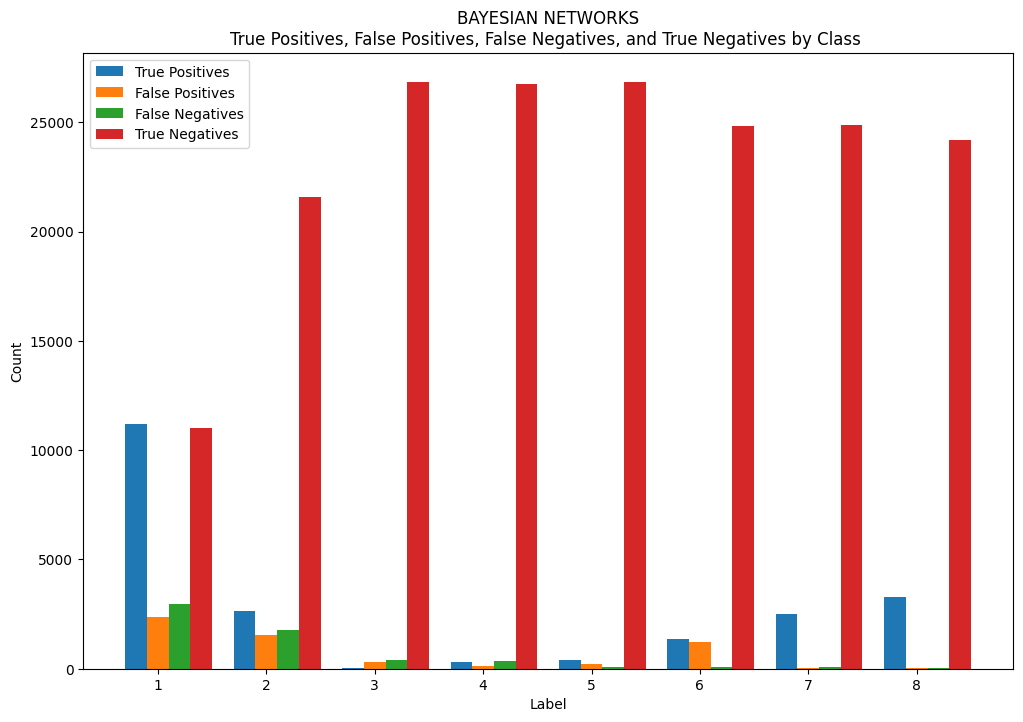

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.2

index = bn_summary_df['Label']

bar1 = plt.bar(index, bn_summary_df['TP'], bar_width, label='True Positives')
bar2 = plt.bar(index + bar_width, bn_summary_df['FP'], bar_width, label='False Positives')
bar3 = plt.bar(index + 2 * bar_width, bn_summary_df['FN'], bar_width, label='False Negatives')
bar4 = plt.bar(index + 3 * bar_width, bn_summary_df['TN'], bar_width, label='True Negatives')

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('BAYESIAN NETWORKS\nTrue Positives, False Positives, False Negatives, and True Negatives by Class ')
plt.xticks(index + bar_width, bn_summary_df['Label'])
plt.legend()

plt.show()